## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [2]:
# Setup environment
#!apt-get -qq install xxd
#!pip install pandas numpy matplotlib
#!pip install tensorflow==2.0.0-rc1

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "punch",
    "flex",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv(gesture + ".csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.16.1

Processing index 0 for gesture 'punch'.
	There are 12 recordings of the punch gesture.
Processing index 1 for gesture 'flex'.
	There are 12 recordings of the flex gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [5]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4243 - mae: 0.6143 - val_loss: 0.2716 - val_mae: 0.5185
Epoch 2/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2572 - mae: 0.5043 - val_loss: 0.2735 - val_mae: 0.5198
Epoch 3/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2588 - mae: 0.5055 - val_loss: 0.2744 - val_mae: 0.5204
Epoch 4/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2591 - mae: 0.5057 - val_loss: 0.2743 - val_mae: 0.5202
Epoch 5/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2593 - mae: 0.5055 - val_loss: 0.2776 - val_mae: 0.5228
Epoch 6/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2590 - mae: 0.5048 - val_loss: 0.2737 - val_mae: 0.5200
Epoch 7/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2565 - mae: 0.5031 - val_loss: 0.2747 - val_mae: 0.5206
Epoch 8/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2571 - mae: 0.5035 - val_loss: 0.2733 - val_mae: 0.5193
Epoch 9/600
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.256

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

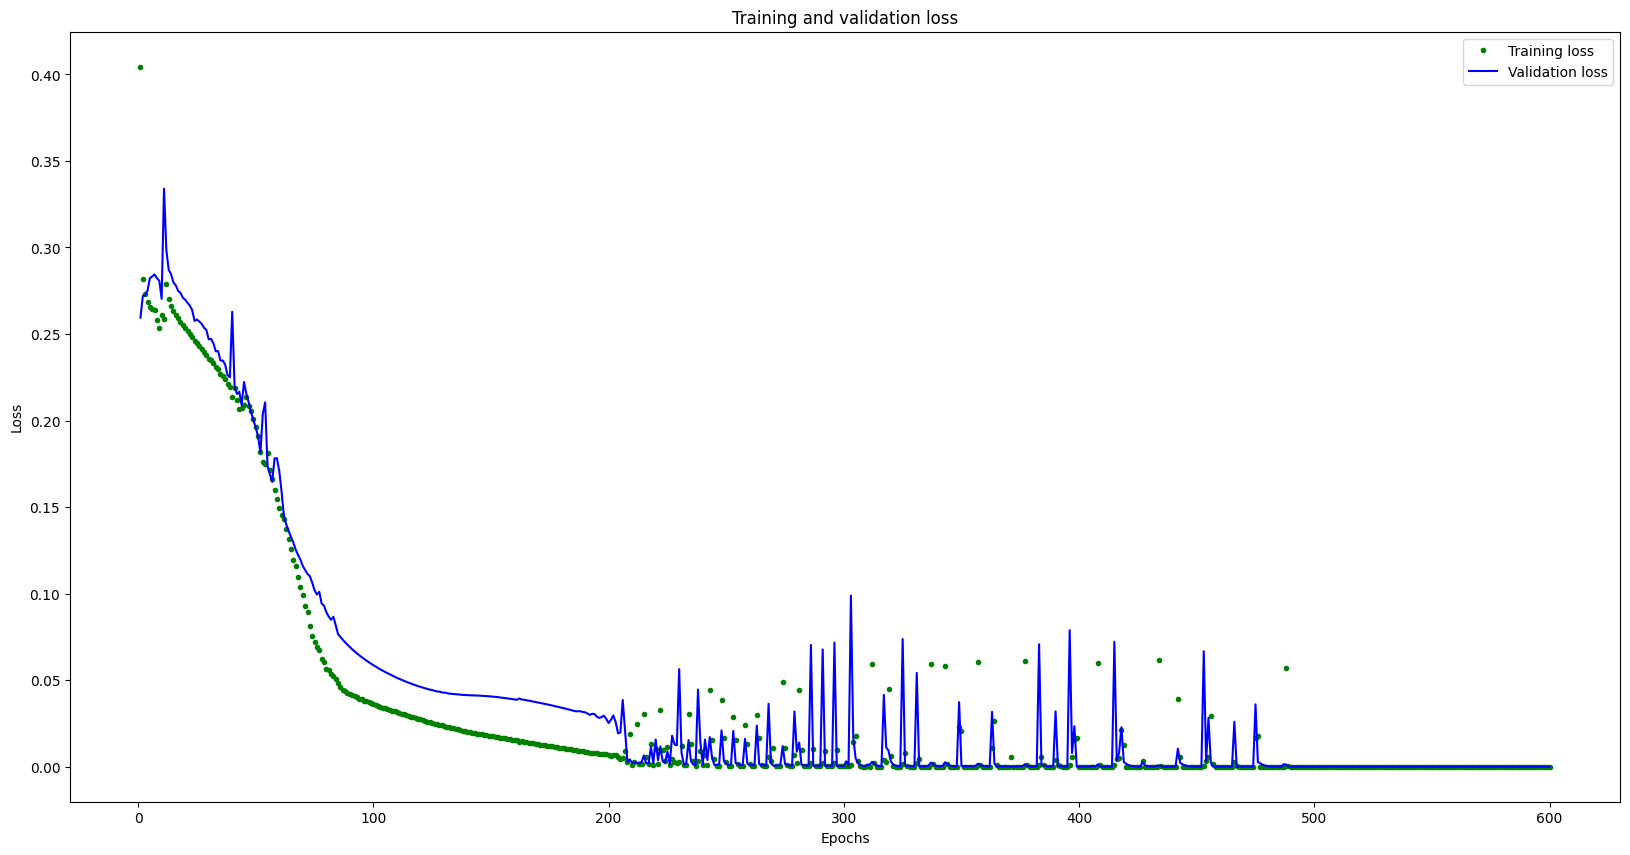

[20.0, 10.0]


In [8]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Run with Test Data
Put our test data into the model and plot the predictions


In [6]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
predictions =
 [[0.    1.   ]
 [1.    0.   ]
 [0.997 0.003]
 [0.    1.   ]]
actual =
 [[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\pablo\AppData\Local\Temp\tmpy7xptp_n\assets


INFO:tensorflow:Assets written to: C:\Users\pablo\AppData\Local\Temp\tmpy7xptp_n\assets


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")